# Binary Classification of NSL-KDD Dataset

In [1]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

# Tensorflow and Keras
import tensorflow as tf
import time

## Dataset Visualization and Preprocessing

In [2]:
# Column Labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

# Datasets
train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [3]:
# Training Set Preview
print(df_train.shape)
print("--------------------")
print(df_train.head())
print("--------------------")
print(df_train.info())

(125973, 43)
--------------------
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60             

In [4]:
# Testing Set Preview
print(df_test.shape)
print("--------------------")
print(df_test.head())
print("--------------------")
print(df_test.info())

print(df_train['flag'].unique())

(22544, 43)
--------------------
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06        

In [5]:
# Check for duplicates
print("Duplicates in Train: ", df_train.duplicated().sum())
print("Duplicates in Test: ", df_test.duplicated().sum())

# Check for missing values
print("-----------------------------------")
print("Rows with missing values - train: ", df_train.isnull().sum())
print("-----------------------------------")
print("Rows with missing values - test: ", df_test.isnull().sum())

Duplicates in Train:  0
Duplicates in Test:  0
-----------------------------------
Rows with missing values - train:  duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate             

### Test: Trying to limit only specific attacks

In [6]:
# List of DDoS/DoS attacks for the training dataset
train_ddos = [
    "neptune",
    "smurf",
    "pod",
    "teardrop",
    "land",
    "back"
]

# List of DDoS/DoS attacks for the test dataset, including unknowns
test_ddos = [
    "apache2",
    "processtable",
    "mailbomb",
    "udpstorm",
]

# Combine the DDoS/DoS attacks
ddos_attacks = train_ddos + test_ddos

# Add "normal" to ddos_attacks for filtering
allowed_samples = ddos_attacks + ["normal"]

# Filter for DDoS/DoS attacks and normal samples in the training dataset
df_train_binary = df_train[df_train['attack'].isin(allowed_samples)].copy()

# Filter for DDoS/DoS attacks and normal samples in the test dataset
df_test_binary = df_test[df_test['attack'].isin(allowed_samples)].copy()

# Now, convert all attack types (DDoS/DoS) to 'attack'
df_train_binary['attack'] = df_train_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

df_test_binary['attack'] = df_test_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

In [7]:
# Helper function to plot bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

<Axes: xlabel='attack'>

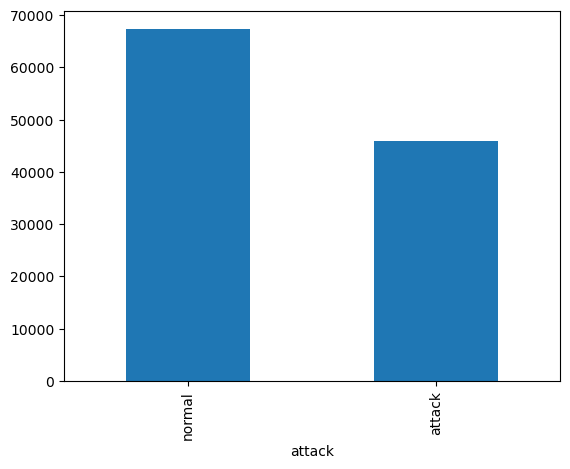

In [8]:
df_train_binary['attack'].value_counts().plot(kind='bar')

### Acquring only obtainable features from Networking Monitoring Tools

In [9]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
    'urgent',
    'duration',
    'wrong_fragment',
    'count',
    'srv_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count'
]

# This feature is directly obtainable but very low selectKBest score
non_directly_obtainable_features += ['protocol_type']

X_train = df_train_binary.drop(non_directly_obtainable_features, axis=1)
X_test = df_test_binary.drop(non_directly_obtainable_features, axis=1)

In [10]:
# Grouping by attack type, service, and flag to find commonly associated combinations
grouped_X_train = X_train.groupby(['attack', 'service', 'flag']).size().reset_index(name='counts')
grouped_X_test = X_test.groupby(['attack', 'service', 'flag']).size().reset_index(name='counts')

# Saving grouped data to CSVs
grouped_X_train.to_csv('grouped_X_train.csv', index=False)
grouped_X_test.to_csv('grouped_X_test.csv', index=False)

print("X_train and X_test grouped by 'attack', 'service', 'flag' and saved to CSV.")

X_train and X_test grouped by 'attack', 'service', 'flag' and saved to CSV.


In [11]:
X_train.to_csv('X_train.csv', index=False)

In [12]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Set 'attack' to 1 and 'normal' to 0 in both training and test sets
X_train['attack'] = X_train['attack'].map({'attack': 1, 'normal': 0})
X_test['attack'] = X_test['attack'].map({'attack': 1, 'normal': 0})

# Encode other categorical features
columns_to_encode = ['service', 'flag']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    le.fit(df_train_binary[column])
    
    # Apply transformation to training and test sets
    X_train[column] = le.transform(X_train[column])
    X_test[column] = X_test[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    # Save the label map for reference (this replaces saving the encoder itself)
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

    # Save the label encoder for later use
    joblib.dump(le, f'{column}_encoder.joblib')

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")

Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pop_2': 41, 'pop_3': 42, 'printer': 43, 'private': 44, 'red_i': 45, 'remote_job': 46, 'rje': 47, 'shell': 48, 'smtp': 49, 'sql_net': 50, 'ssh': 51, 'sunrpc': 52, 'supdup': 53, 'systat': 54, 'telnet': 55, 'tftp_u': 56, 'tim_i': 57, 'time': 58, 'urh_i': 59, 'urp_i': 60, 'uucp': 61, 'uucp_path': 62, 'vmnet': 63, 'whois': 64}
Mapping for flag: {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTR': 3, 'S0': 4, 'S1': 5, 'S2': 6, 'S3': 7, 'SF': 

In [13]:
# Split the data into features (x) and target (y) - Level is unknown in real-time
y_train = X_train['attack']
X_train = X_train.drop('attack', axis=1)
y_test = X_test['attack']
X_test = X_test.drop('attack', axis=1)

In [14]:
# Ratio of Training to Testing Data
# Step 1: Determine the sizes of training and test sets
train_size = len(df_train_binary)
test_size = len(df_test_binary)

# Step 2: Calculate the total number of samples
total_size = train_size + test_size

# Step 3: Calculate the ratios
train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")


Train ratio: 0.87
Test ratio: 0.13


### Feature Engineering

In [15]:
# SelectKBest for Top 4 Features
top_4_features = SelectKBest(mutual_info_classif, k=4)
top_4_features.fit(X_train, y_train)
X_train.columns[top_4_features.get_support()]

Index(['service', 'flag', 'src_bytes', 'dst_bytes'], dtype='object')

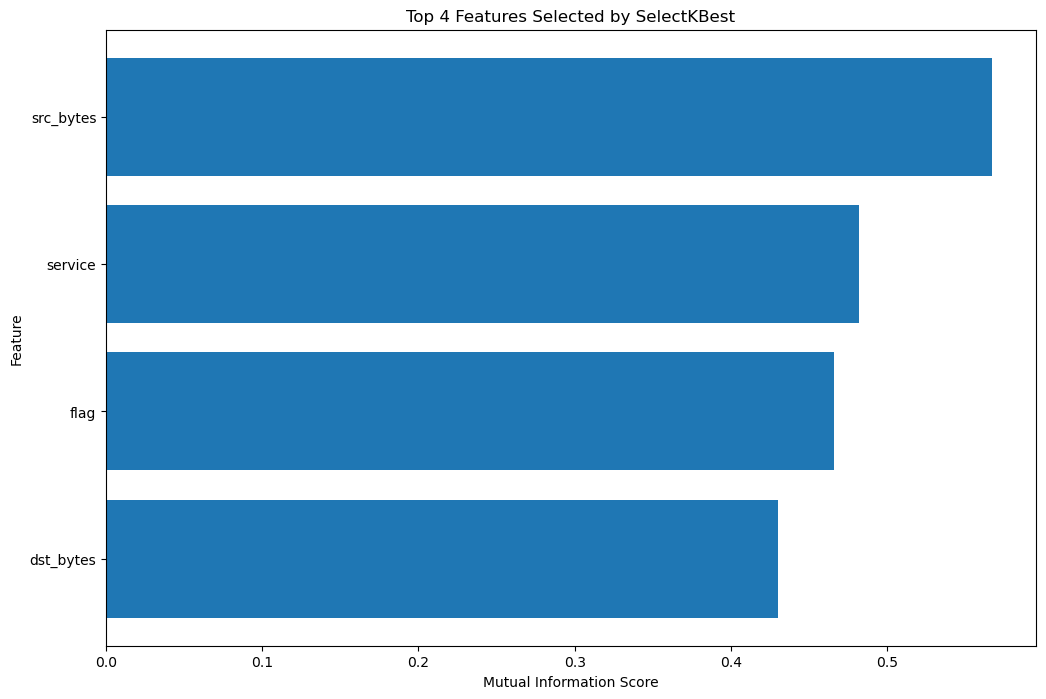

In [16]:
# Get the mask for the selected features
mask = top_4_features.get_support()

# Get the feature scores
feature_scores = top_4_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 4 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [17]:
top_4_features = ['service', 'flag', 'src_bytes','dst_bytes']

X_train = X_train[top_4_features]
X_test = X_test[top_4_features]

### Scale Data

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sampled = False

# Save the scaler for later use
joblib.dump(scaler, 'standard_scaler.joblib')

['standard_scaler.joblib']

In [33]:
# Save X_train as a CSV file
X_train_df = pd.DataFrame(X_train, columns=top_4_features)
X_train_df.to_csv('X_train.csv', index=False)

## ML Results

In [19]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time

# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Save the trained model
    model_filename = f"{name.replace(' ', '_').lower()}_binary_model.joblib"
    joblib.dump(model, model_filename)
    print(f"Model {name} saved as {model_filename}")

    # Predict on the test set
    start_pred_time = time.time()
    y_pred_test = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    y_pred_train = model.predict(X_train)  # Predict on the training set for comparison

    # Calculate evaluation metrics on the test set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='binary', zero_division=1)
    recall_test = recall_score(y_test, y_pred_test, average='binary', zero_division=1)
    f1_test = f1_score(y_test, y_pred_test, average='binary', zero_division=1)

    # Calculate evaluation metrics on the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='binary', zero_division=1)
    recall_train = recall_score(y_train, y_pred_train, average='binary', zero_division=1)
    f1_train = f1_score(y_train, y_pred_train, average='binary', zero_division=1)

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred_test)
    cr = classification_report(y_test, y_pred_test)

    # Store the results
    results[name] = {
        "train_accuracy": accuracy_train,
        "train_precision": precision_train,
        "train_recall": recall_train,
        "train_f1": f1_train,
        "test_accuracy": accuracy_test,
        "test_precision": precision_test,
        "test_recall": recall_test,
        "test_f1": f1_test,
        "train_time": train_time,
        "pred_time": pred_time,
        "confusion_matrix": cm,
        "classification_report": cr
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Train Accuracy: {accuracy_train}')
    print(f'Test Accuracy: {accuracy_test}')
    print(f'Train Precision: {precision_train}')
    print(f'Test Precision: {precision_test}')
    print(f'Train Recall: {recall_train}')
    print(f'Test Recall: {recall_test}')
    print(f'Train F1 Score: {f1_train}')
    print(f'Test F1 Score: {f1_test}')
    print(f'Training Time: {train_time:.4f} seconds')
    print(f'Prediction Time: {pred_time:.4f} seconds')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Classification Report:\n{cr}')

Model XGBoost saved as xgboost_binary_model.joblib
--- XGBoost ---
Train Accuracy: 0.9945086960360201
Test Accuracy: 0.9296988758809482
Train Precision: 0.9905580700348658
Test Precision: 0.9795918367346939
Train Recall: 0.9959500947155269
Test Recall: 0.8559935639581657
Train F1 Score: 0.9932467645270564
Test F1 Score: 0.9136314847942755
Training Time: 0.3033 seconds
Prediction Time: 0.0050 seconds
Confusion Matrix:
[[9578  133]
 [1074 6384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9711
           1       0.98      0.86      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.93      0.93      0.93     17169

Model Logistic Regression saved as logistic_regression_binary_model.joblib
--- Logistic Regression ---
Train Accuracy: 0.9276507460051205
Test Accuracy: 0.8778612615760965
Train Precision: 0.92006590666

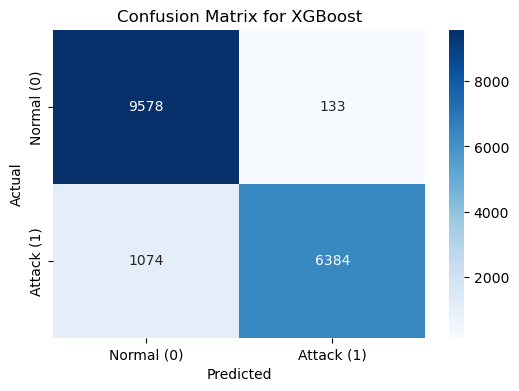

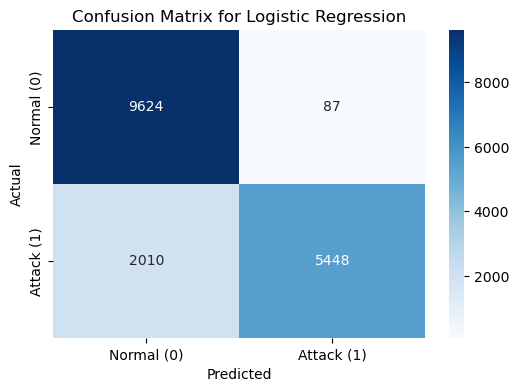

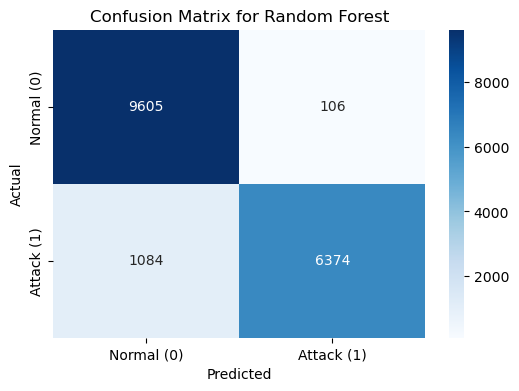

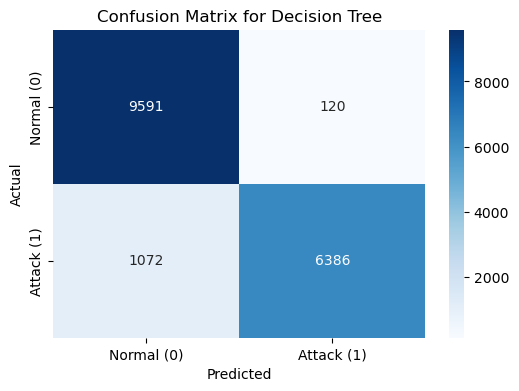

In [20]:
# Plot the confusion matrix for each model
for model_name, metrics in results.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Attack (1)'], yticklabels=['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

## DL Results

### CNN-LSTM

In [75]:
# Reshape x_train and x_test to 3D for CNN-LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape becomes (125973, 4, 1)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))      # shape becomes (22544, 4, 1)


In [76]:
print(X_train_reshaped)

[[[-0.62314033]
  [ 0.77298822]
  [-0.02416949]
  [-0.05230875]]

 [[ 0.80265342]
  [ 0.77298822]
  [-0.02523933]
  [-0.05230875]]

 [[ 1.07423318]
  [-0.90596126]
  [-0.02569207]
  [-0.05230875]]

 ...

 [[ 1.41370788]
  [ 0.77298822]
  [-0.01877379]
  [-0.04470814]]

 [[-0.14787574]
  [-0.90596126]
  [-0.02569207]
  [-0.05230875]]

 [[-0.62314033]
  [ 0.77298822]
  [-0.02522383]
  [-0.05230875]]]


In [77]:
print(X_train_reshaped.shape)
print(X_train.shape)

(113270, 4, 1)
(113270, 4)


In [78]:
import tensorflow as tf

cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling1D(pool_size=1), 
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    # LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    # Output layer -> Try for with Softmax instead 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
cnn_lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2, 128)         │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,265 (1.48 MB)

 Trainable params: 387,265 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
import time

# Record the start time
start_time = time.time()

# Train the model
cnn_lstm_model.fit(X_train_reshaped, y_train, 
                   epochs=50, 
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[lr_scheduler, early_stopping])

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

# Save the trained model to a file
cnn_lstm_model.save('cnn_lstm_binary_model.keras')  
print("Model saved as 'cnn_lstm_binary_model.keras'")

Epoch 1/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9010 - loss: 0.3211 - val_accuracy: 0.9650 - val_loss: 0.1146 - learning_rate: 5.0000e-04
Epoch 2/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9655 - loss: 0.1190 - val_accuracy: 0.9792 - val_loss: 0.0781 - learning_rate: 5.0000e-04
Epoch 3/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9746 - loss: 0.0916 - val_accuracy: 0.9812 - val_loss: 0.0797 - learning_rate: 5.0000e-04
Epoch 4/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9757 - loss: 0.0845 - val_accuracy: 0.9794 - val_loss: 0.0637 - learning_rate: 5.0000e-04
Epoch 5/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9771 - loss: 0.0764 - val_accuracy: 0.9796 - val_loss: 0.0640 - learning_rate: 5.0000e-04
Epoch 6/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9773 - loss: 0.0746 - val_accuracy: 0.9736 - val_loss: 0.0645 - learning_rate: 5.0000e-04
Epoch 7/50
1416/1416 ━━━━━━━━━━━━━━━━━━━

In [80]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred_prob = cnn_lstm_model.predict(X_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.4f} seconds")

# Convert the predictions from probabilities to binary labels (0 or 1)
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Convert the true labels to 'attack'/'normal' format
y_test_decoded = ['attack' if label == 1 else 'normal' for label in y_test]

# Convert predicted binary labels to 'attack'/'normal'
y_pred_decoded = ['attack' if label == 1 else 'normal' for label in y_pred_binary]

# Print the decoded predictions and true labels
print("Predicted Labels:", y_pred_decoded)
print("True Labels:", y_test_decoded)


537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.5968 seconds
Predicted Labels: ['attack', 'attack', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack', 'attack', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack', 'attack', 'normal', 'normal', 'attack', 'attack', 'normal', 'normal', 'attack', 'normal', 'attack', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack', 'normal', 'normal', 'normal', 'attack', 'normal', 'attack', 'attack', 'normal', 'normal', 'normal', 'attack', 'attack', 'normal', 'attack', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack', 'attack', 'normal', 'attack', 'normal', 'normal', 'normal', 'attack', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack', 'attack', 'attack', 'normal', 'normal', 'normal', 'attack', 'normal', 'normal', 'normal', 'normal', 'attack', 'normal', 'normal', 'normal', 'attack', 'attack', 'attack', 'normal', 'attack', 'normal', 'attack', 'normal', 'normal', 'attack', 'normal', 'normal'

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert 'attack'/'normal' back to numeric for evaluation
y_test_numeric = [1 if label == 'attack' else 0 for label in y_test_decoded]
y_pred_numeric = [1 if label == 'attack' else 0 for label in y_pred_decoded]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_numeric, y_pred_numeric)
precision = precision_score(y_test_numeric, y_pred_numeric)
recall = recall_score(y_test_numeric, y_pred_numeric)
f1 = f1_score(y_test_numeric, y_pred_numeric)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

Accuracy: 0.93290
Precision: 0.98538
Recall: 0.85827
F1 Score: 0.91744


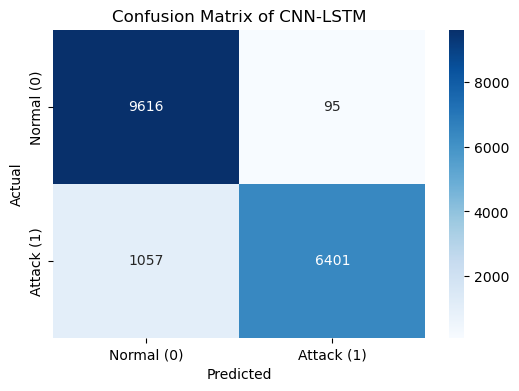

              precision    recall  f1-score   support

      normal    0.90097   0.99022   0.94349      9711
      attack    0.98538   0.85827   0.91744      7458

    accuracy                        0.93290     17169
   macro avg    0.94317   0.92425   0.93046     17169
weighted avg    0.93763   0.93290   0.93217     17169



In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'attack'/'normal' back to numeric for evaluation
y_test_numeric = [1 if label == 'attack' else 0 for label in y_test_decoded]
y_pred_numeric = [1 if label == 'attack' else 0 for label in y_pred_decoded]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, y_pred_numeric)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Attack (1)'], yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN-LSTM')
plt.show()

# Print the classification report
print(classification_report(y_test_numeric, y_pred_numeric, target_names=['normal', 'attack'], digits=5))


### Autoencoder

In [83]:
# Get the input dimension
input_dim = X_train_reshaped.shape[1]
print(input_dim)

4


In [90]:
# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(1, 8, activation='tanh', padding='same'),
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 2, 16)          │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 4, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,224 (8.69 KB)

 Trainable params: 2,224 (8.69 KB)

 Non-trainable params: 0 (0.00 B)

None


In [91]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    X_train_reshaped, 
    X_train_reshaped, 
    epochs=50, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time

Epoch 1/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4554 - val_loss: 1.3901
Epoch 2/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3360 - val_loss: 1.3897
Epoch 3/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3589 - val_loss: 1.3887
Epoch 4/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3947 - val_loss: 1.3899
Epoch 5/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2910 - val_loss: 1.3883
Epoch 6/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3052 - val_loss: 1.3889
Epoch 7/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3204 - val_loss: 1.3883
Epoch 8/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3029 - val_loss: 1.3882
Epoch 9/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4151 - val_loss: 1.3880
Epoch 10/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2467 - val_loss: 1.3968
Epoch 11/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4422 - val_loss: 1.3880
Epoch 12/50
1416/1416 ━━━━━━━━

In [92]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(X_train_reshaped)
encoded_test = encoder.predict(X_test_reshaped)

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step


In [93]:
# Save the encoder model
encoder.save('encoder_model.keras')

In [94]:
# Flatten the encoded data for training XGBoost
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

In [100]:
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

model = XGBClassifier(
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

print("Total training time for AE-XGB:", train_time + autoencoder_training_time)

# Save the trained AE-XGB model to a file
model_filename = "ae_xgb_binary_model.joblib"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# If your labels are already 0 and 1, use them directly for evaluation
y_test_decoded = y_test
y_pred_decoded = y_pred

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, digits=5, zero_division=1)

# Store the results
results = {}
results["AE-XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- AE-XGBoost ---')
print(f'Accuracy: {accuracy:.5}')
print(f'Precision: {precision:.5}')
print(f'Recall: {recall:.5}')
print(f'F1 Score: {f1:.5}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {autoencoder_training_time+train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')


Total training time for AE-XGB: 81.25585293769836
Model saved as ae_xgb_model_binary.joblib
--- AE-XGBoost ---
Accuracy: 0.92475
Precision: 0.97533
Recall: 0.84822
F1 Score: 0.90734
Confusion Matrix:
[[9551  160]
 [1132 6326]]
Classification Report:
              precision    recall  f1-score   support

           0    0.89404   0.98352   0.93665      9711
           1    0.97533   0.84822   0.90734      7458

    accuracy                        0.92475     17169
   macro avg    0.93468   0.91587   0.92200     17169
weighted avg    0.92935   0.92475   0.92392     17169

Training Time: 81.25585293769836 seconds
Prediction Time: 0.004305124282836914 seconds


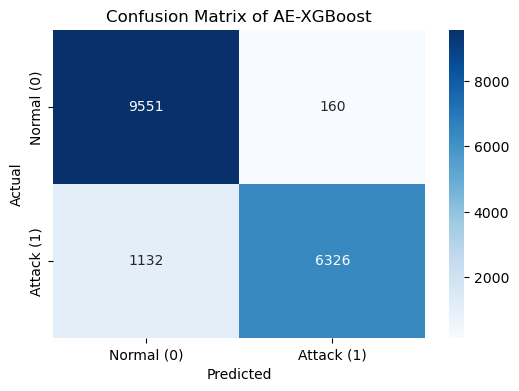

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'attack'/'normal' back to numeric for evaluation
y_test_numeric = [1 if label == 'attack' else 0 for label in y_test_decoded]
y_pred_numeric = [1 if label == 'attack' else 0 for label in y_pred_decoded]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Attack (1)'], yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of AE-XGBoost')
plt.show()
